# Logistic Regression

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('treated_data.csv')

In [ ]:
def evaluate(y_true, y_prob, titulo="Model"):
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{titulo}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision:  {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC-ROC:   {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0,1], [0,1], '--')
    plt.title(f"ROC Curve - {titulo}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
X = df.drop(['isFraud', 'Unnamed: 0'], axis=1)
y = df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

## Hold-Out Validation


Logistic Regression - Test
Accuracy:  0.9992
Precision:  0.9059
Recall:    0.4381
AUC-ROC:   0.9818


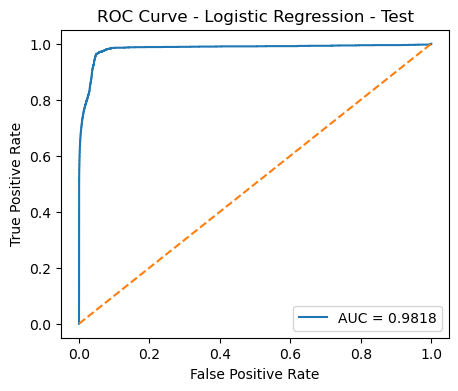

In [ ]:
model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

y_prob = model.predict_proba(X_test)[:,1]

evaluate(y_test, y_prob, "Logistic Regression - Test")

## K-Fold


K-Fold 1
Accuracy:  0.9992
Precision:  0.9047
Recall:    0.4254
AUC-ROC:   0.9783


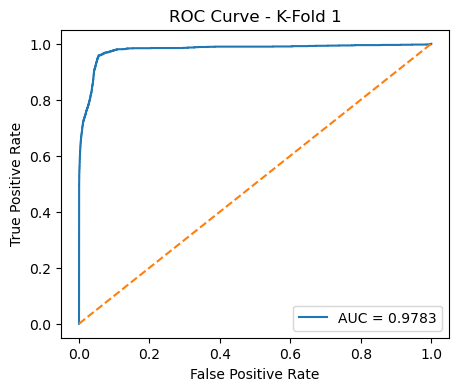


K-Fold 2
Accuracy:  0.9992
Precision:  0.8919
Recall:    0.4451
AUC-ROC:   0.9789


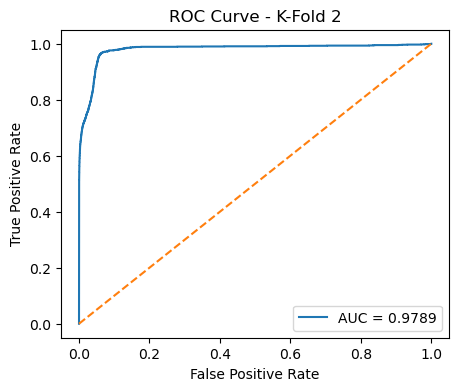


K-Fold 3
Accuracy:  0.9992
Precision:  0.8708
Recall:    0.4317
AUC-ROC:   0.9771


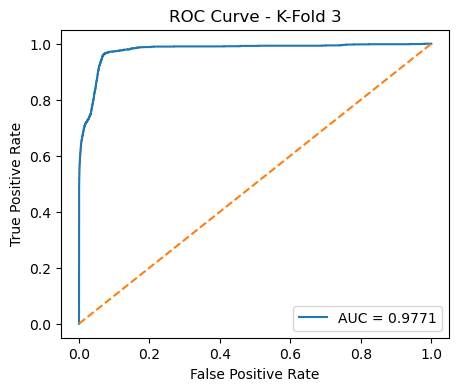


K-Fold 4
Accuracy:  0.9992
Precision:  0.8828
Recall:    0.4380
AUC-ROC:   0.9777


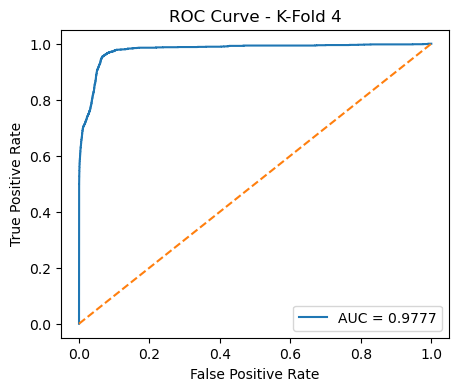


K-Fold 5
Accuracy:  0.9992
Precision:  0.8501
Recall:    0.4374
AUC-ROC:   0.9813


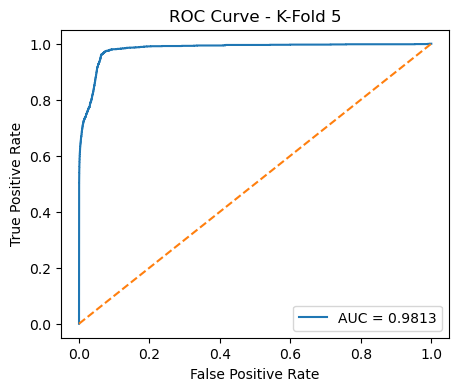

In [7]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
for train_idx, test_idx in kf.split(X):
    X_train_k, X_test_k = X.iloc[train_idx], X.iloc[test_idx]
    y_train_k, y_test_k = y.iloc[train_idx], y.iloc[test_idx]

    model_k = LogisticRegression(max_iter=2000)
    model_k.fit(X_train_k, y_train_k)

    y_prob_k = model_k.predict_proba(X_test_k)[:,1]

    evaluate(y_test_k, y_prob_k, f"K-Fold {fold}")
    fold += 1

## Class Weights

Weights: {0: 0.5006450389368385, 1: 388.07350250091497}

Logistic Regression - Class Weight
Accuracy:  0.9662
Precision:  0.0356
Recall:    0.9750
AUC-ROC:   0.9904


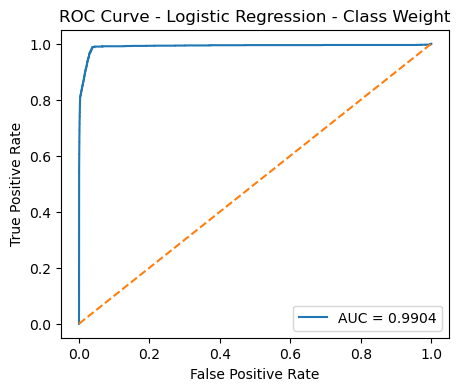

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)

class_weights = {0: class_weights[0], 1: class_weights[1]}
print("Weights:", class_weights)

model_w = LogisticRegression(class_weight=class_weights, max_iter=2000)
model_w.fit(X_train, y_train)

y_prob_w = model_w.predict_proba(X_test)[:,1]

evaluate(y_test, y_prob_w, "Logistic Regression - Class Weight")

## Undersampling


Undersampling (Balanced Train, Real Test)
Accuracy:  0.9909
Precision:  0.1121
Recall:    0.8868
AUC-ROC:   0.9915


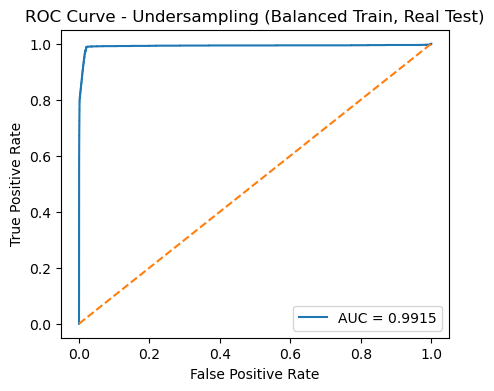

In [10]:
df_train = pd.concat([X_train, y_train], axis=1)
df0 = df_train[df_train['isFraud'] == 0]
df1 = df_train[df_train['isFraud'] == 1]

df0_under = resample(
    df0,
    replace=False,
    n_samples=len(df1) * 5,
    random_state=42
)

df_train_bal = pd.concat([df0_under, df1])

X_train_b = df_train_bal.drop(['isFraud'], axis=1)
y_train_b = df_train_bal['isFraud']

model_b = LogisticRegression(max_iter=2000)
model_b.fit(X_train_b, y_train_b)

y_prob_real = model_b.predict_proba(X_test)[:,1]

evaluate(y_test, y_prob_real, "Undersampling (Balanced Train, Real Test)")